# 1. Introduction 

Collateral Reblance Pool (CRP) dynamically rebalances Collateral to ensure the ayToken minted (i.e. the loan) remains solvent, especially in an adverse market environment (i.e. the value of the loan does not exceed the value of Collateral). This dynamic rebalancing, together with a careful choice of the key parameters (including LTV and volatility assumption) allows ALEX to eliminate the liquidation needs. Any residual gap risk (which CRP cannot address entirely) is addressed through maintaining a strong reserve fund. When a Borrower mints ayToken by providing appropriate Collateral, the Collateral is converted into a basket of Collateral and Token, with the weights determined by CRP.

In this notebook, we will help you understand the key attributes of the CRP pool by answering: 
1.  How does CRP achieve the dynamic rebalances with weights determined by CRP? 
2.  How does CRP perform in different market environments? 
3.  In which parameters space (including LTV and volatility assumption), the CRP would maintain a low default risk and a high pool-value level to a collateral ratio (PVCR)?  

Since there is no close form of CPR performance, we use Monte Carlo simulation to show the results based on predicted the future scenarios.  Based on the simulation results: [Conculsion to be inserted...]


# 2. CRP dynamic rebalance mechanisam 

The following diagram illustrates how CRP dynamic rebalances with the weights determined by CRP.  Once the pool updates new weights based on the Black Shoal option calculation, the pool will be rebalanced by arbitragers to bring the spot price equaled to the outside market. (???)  We leave the mathematical formula of the weight to session 4.    

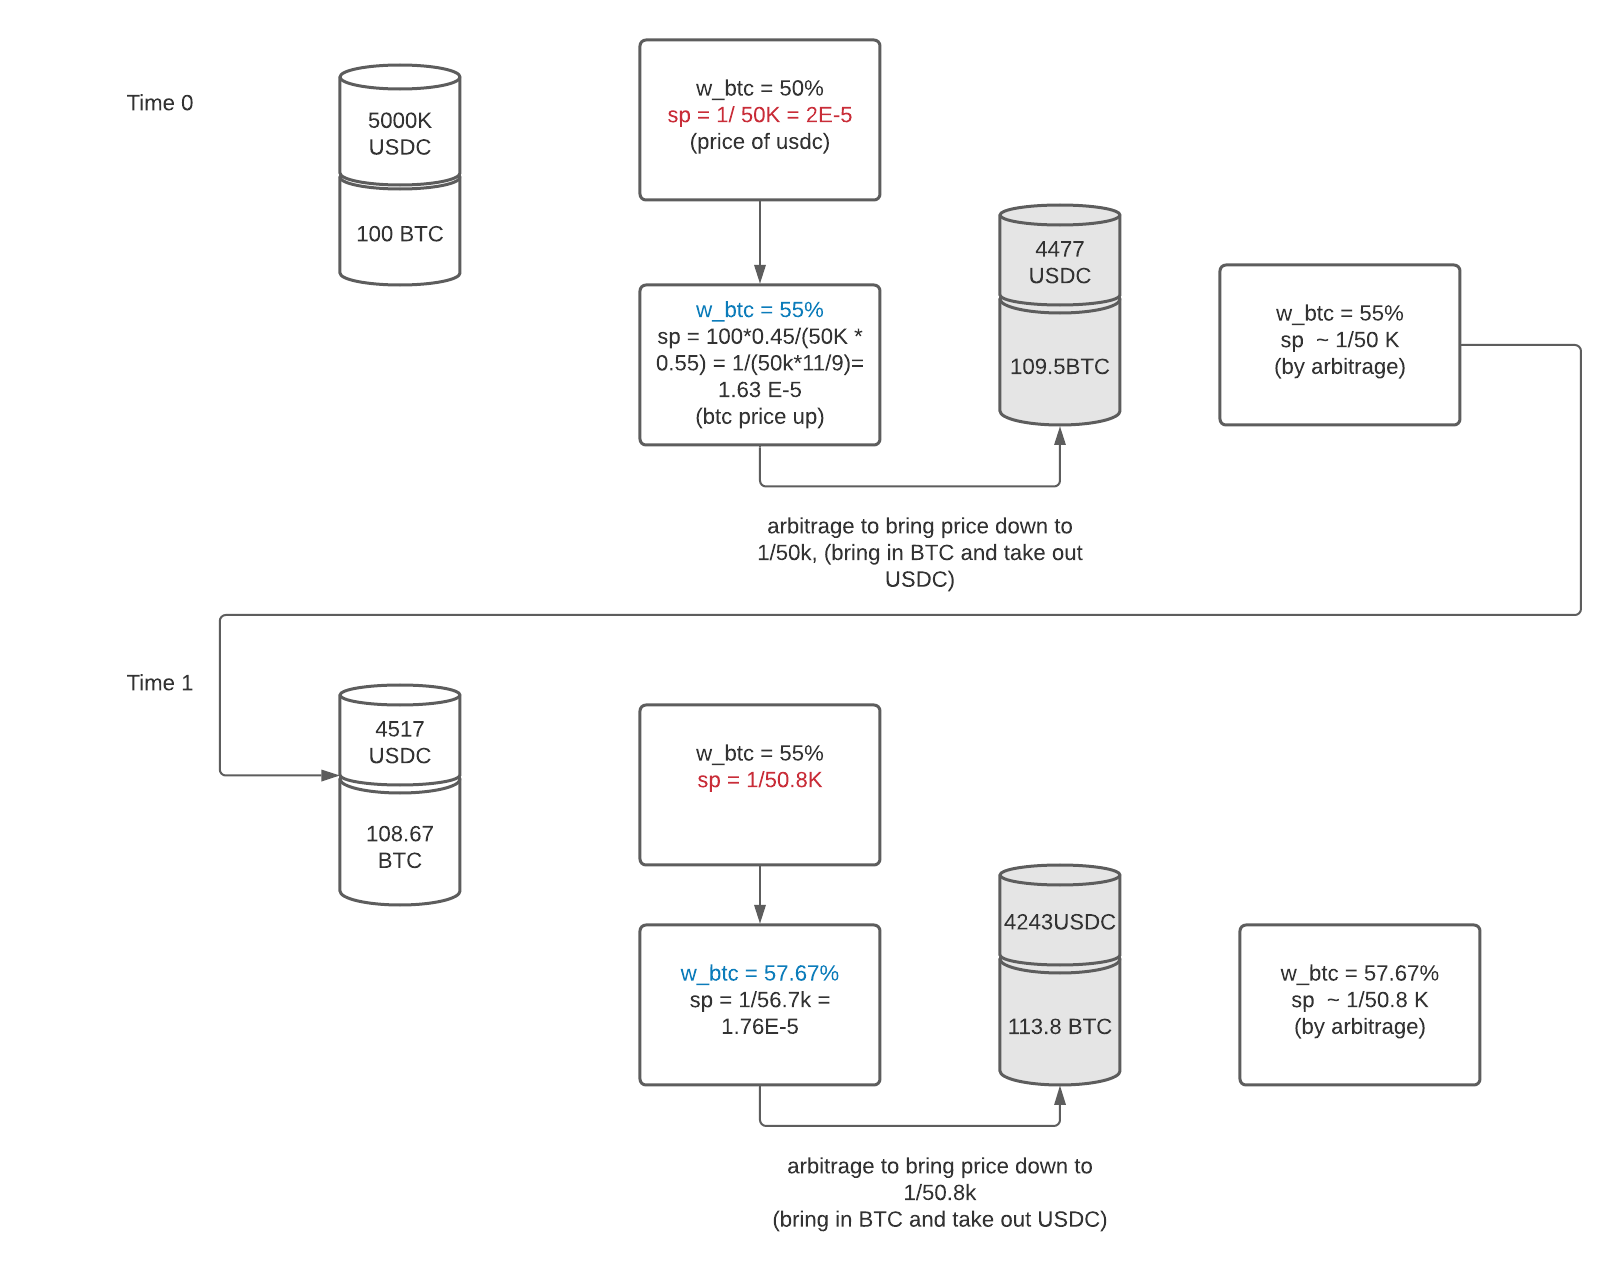


# 3.  CRP perfomance by Monte Carlo Simulations  [WIP] 

In this session, we want to simulate how CRP performs in different market environments.  Basically, a CRP would serve as an agent (bot) response to the actual market environment by updating the pool weight based on current token price $p$, real price volatility $\eta$, and estimated price volatility $\sigma$.  We simplify the market environment and let the token price change follow a linear growth trend with variation, formally named the Geometric Brownian Motion (https://en.wikipedia.org/wiki/Geometric_Brownian_motion).  By setting up different growth rate $r$ and volatility $\eta$, we can approximately mimic different market environments.  

Two metrics an LP would be very interested to know are 1) event of default, i.e., when the Loan to Value >1 at any time point, and 2)pool-value to the collateral ratio (PVCR), which is defined as $\frac{PoolValue(t)}{Collateral}$.  We can empirically estimate the default risk and confidence intervals of pool-value to the collateral ratio for any given parameters by conducting Monte Carlo simulations. 

For simplicity, fees and token APY are not considered for now. We set initial weights to be 50/50 and loan lifetime equals 91 days, and all key parameters various in the following parameters space: 
### Pool parameters 

   (1) Initial LTV: range from 0.7 to 0.95
    
   (2) Black scholes volatility: $\sigma$ range from 0.1 - 1.0  

### Market enviroment        
   (3) Growth rate: $r$ range from $[-2, 2]$ (corresponding to 25% or 200% of the initial price)
   
   (4) Growth rate volatility: $\eta$ range from 0.1 - 1.0
   

### Episode 

For each parameter setup (1) to (4), we activate the CRP and monitor its performance during the whole loan life term (called a episode). At each scheduled time point t (e.g. dayily), we rebalance Collateral and token according to $\eqref{eq:CRP}$, and reocrd and plot:

1. Token price at time t 
2. Reblanced weight at time t 
3. Daily pool value loss (relative to collaterals) 
4. LTV without slippage 
5. LTV with reblancing slippage cost.  
6. Scatter plot of ytoken weight and pool value loss 
7. PVTC without slippage 
8. PVTC with reblancing slippage cost
9. (8) relative to (7). 


Each episode will be one relization of the CRP based on a predited future.  Repeating the episode 100 times, we can estimate the chance of default and confidenct interval of the PVCR by the maturinity time. 



### Simulation results:
For each selected combination (1) to (4), run the process 100 times and count the number of events that LVT(t) > 1 at any time point.  Report the frequency by LTV0 and growth rate for a given volatility setup.     
    
For example this is the simulation results when growth rate volatility is high, and black sholes volatility is under-estimated. 
The size of button indicate the chance of default when LVT is hight, even the growth rate is low.    


# 4 How CRP determine the weights 

CRP determines the weights based on the prevailing LTV and uses the following formula:

\begin{equation}
   \begin{cases}
      w_{Token} = N(d_1) \\
      w_{Collateral} = (1 - w_{Token}) \\
      d_1 = \frac{1}{\sigma \sqrt{(t)}} [ln (\frac{P_t}{P_0}) + t \cdot \frac{\sigma^2}{2}] 
    \end{cases}       
    \label{eq:CRP} \tag{1} 
\end{equation}

Some readers may note the similarity of the above formula to the Black & Scholes delta, because it is. CRP essentially implements a delta replicating strategy of a call option on Token / Collateral, buying more Token when LTV moves higher and vice versa.


Token price changes follow: 
$$ log(P_t) = log(P_0) + (r - \frac{\eta^2}{2}) \cdot \Delta t + \eta W_t $$
where $W_t$ is a Brownian motion. 

Derive token locked value at time t  
from 

\begin{equation}
   \begin{cases}
      C(t+1) =  U(t) \cdot P_{t+1} + B(t)\\
      U(t+1) = C(t+1) \cdot w_{Token}(t+1)/P_{t+1}\\
      B(t+1) = C(t+1)(1-w_{Token}(t+1)) 
    \end{cases}       
\end{equation}

We can rewrite it as 
\begin{equation}
   \begin{cases}
      U(t+1) = U(t)[w_{Token}(t+1) + (1-w_{Token}(t)) \cdot \frac{P_{t} w_{Token}(t+1)}{P_{t+1} w_{Token}(t)}] \\
      B(t+1) = U(t+1) \cdot P_{t+1} \frac{1- w_{Token}(t+1)}{w_{Token}(t+1)}\\
      C(t+1) = U(t) \cdot P_{t+1} + B(t)
    \end{cases}       
\end{equation}

Where $C$ = Collateral, $B$ = Collateral_Token_locked and $U$ = Loan_Token_locked. 




    

In [1]:
# plot of liquity 

import scipy 
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.widgets import Slider
import seaborn as sns
import numpy as np 
import random
import pandas as pd 
from ipywidgets import *
from scipy.stats import norm


In [98]:
%run rbpool_env.ipynb
# function gen_data_vec_btc
print(help(gen_data_vec_btc))

# import PoolEngin class. 
help(PoolEngine)

Help on function gen_data_vec_btc in module __main__:

gen_data_vec_btc(t, y_price, x, LTV0, bs_vol, Growth_rate, Real_vol)
    Purpose: Simulate a CRP performance during a loan life term (theoretical case, no value lose due to weight change)  
        - x: collateral token (BTC)
        - y: loan token (USDC)
    Assumption: 
        1. Rebalnce following a delta replicating strategy of a call option on Token / Collateral. 
        2. Price percentage change (approximately equals to log(p(t+1)/p(t))) follows a linear growth treand 
           (slope = growth rate) plus a random walk Brownie motion. 
    Input: 
        - t: term of the loan 
        - y_price: price of loan token (e.g. USDC = 3e-5 btc) 
        - x: Collateral token (e.g. BTC)
        - LTV0: inital loan to value at time 0 
        - bs_vol: black shoral option volatilty 
        - Growth_rate: linear growth slope of y price 
        - Real_vol: growth Brownie motion volatility 
    
    Output: 
        - A dataframe

In [104]:
# one simulated crp during a loan life time 
t =  np.linspace(91,0,92)/365
real_vol_0 = 0.2
growth_0 = 2
ltv0 = 0.9
bs_vol0 = 0.2
y_price = 1/35000
Collateral = 200
pool_init_x = 100 
pool_init_y = 3500000
pool_init_wx = 0.5

# generate one simulation based on selected parameters and random price change following the brownie motion, pool value 
# due to rebalnceing will be calculated in the next session. 
episode = gen_data_vec_btc(t,y_price, Collateral, LTV0, bs_vol, Growth_rate, Real_vol)
wt = episode.w_ytoken
oracle_price = episode.y_price

# 
episode_output=[]
pool_value_loss_trading =[0]
pool_value_loss_weights =[]

i=0
rbpool = PoolEngine(x = pool_init_x, y = pool_init_y, w_x = pool_init_wx)
rbpool.value

for i in wt.index:
    if i==0: 
        episode_output.append(rbpool.step(1-wt[i], oracle_price[i]))
    else: 
        # weights stays the same, price change due to trading 
        _trade = rbpool.step(1-wt[i-1], oracle_price[i])
        pool_value_loss_trading.append(_trade[-1])
        # weights changes, bring price back to oracle price  
        episode_output.append(rbpool.step(1-wt[i], oracle_price[i]))

In [115]:
pool_value_loss_trading

[0,
 2.1164878645107024,
 -0.03780534800705482,
 -2.456685183410599,
 1.2907452666827055,
 -1.4928616461541822,
 -1.1790025535984228,
 0.6274106475310646,
 0.4483251362011629,
 2.970075276376747,
 1.5778099430909265,
 4.99553833448536,
 6.12230356806478,
 1.3825448643646894,
 4.022562946871346,
 -3.8805582812892396,
 4.894199255804182,
 -6.324953059606912,
 -1.4005902816398361,
 1.0693565292067433,
 4.33349485629131,
 4.767175828519299,
 3.0049900990790093,
 2.560351951234736,
 1.5706551078935433,
 -1.9344170373941552,
 4.315526970761823,
 -1.773399745637505,
 -3.257209411372372,
 1.2997609876366596,
 2.195389815835455,
 -3.9085078572974794,
 0.4906051607497659,
 5.227096975036716,
 2.960067550623137,
 4.806143708490225,
 -5.429613686232102,
 -1.359930877958817,
 12.437042386157913,
 1.9570878238717455,
 -5.362529473829085,
 -2.8859506052268955,
 8.023578626207069,
 0.986698837595327,
 3.5145865425561453,
 -0.6686082082364351,
 2.4077366957480706,
 2.584026045429141,
 4.472919282387124

In [151]:
# one simulated crp during a loan life time 

t =  np.linspace(91,0,92)/365
real_vol_0 = 0.4
growth_0 = 1
ltv0 = 0.9
bs_vol0 = 0.4
y_price = 1/35000
Collateral = 200
pool_init_x = 100 
pool_init_y = 3500000
pool_init_wx = 0.5

# generate one simulation based on selected parameters and random price change following the brownie motion, pool value 
# due to rebalnceing will be calculated in the next session. 
episode = gen_data_vec_btc(t,y_price, Collateral, LTV0, bs_vol, Growth_rate, Real_vol)
wt = episode.w_ytoken
oracle_price = episode.y_price

# 
episode_output=[]
pool_chg_price_chg =[0]
rbpool = PoolEngine(x = pool_init_x, y = pool_init_y, w_x = pool_init_wx)

for i in wt.index:
    if i==0: 
        episode_output.append(rbpool.step(1-wt[i], oracle_price[i]))
    else: 
        # weights stays the same, price change due to trading 
        _trade = rbpool.step(1-wt[i-1], oracle_price[i])
        pool_chg_price_chg.append(_trade[-1])
        # weights changes, AMM bring the price back to oracle price  
        episode_output.append(rbpool.step(1-wt[i], oracle_price[i]))
        
output = pd.DataFrame(episode_output, columns = ['x', 'y', 'new_wx', 'spot_price', 'oracle_p', 'delta_x', 'value', 'value_change_wt_chg'])
output['pool_chg_price_chg'] = np.array(pool_chg_price_chg)/Collateral
output['pool_chg_wt_chg'] = output.value_change_wt_chg/Collateral
output['pvcr_rebalance'] = output.value/Collateral
output['pvcr_rebal_theory'] = output['pvcr_rebalance'] / episode.pvcr
episode_full = pd.concat([episode, output], axis=1)
episode_full['ltv_rebalance'] = episode_full.borrowed_y/(output.x + output.y*output.oracle_p)

def get_episode_full(t,y_price, Collateral, LTV0, bs_vol, Growth_rate, Real_vol, pool_init_x, pool_init_y, pool_init_wx):
    episode = gen_data_vec_btc(t,y_price, Collateral, LTV0, bs_vol, Growth_rate, Real_vol)
    wt = episode.w_ytoken
    oracle_price = episode.y_price
    episode_output=[]
    pool_chg_price_chg =[0]
    # add pool reblancing cost and trading cost 
    rbpool = PoolEngine(x = pool_init_x, y = pool_init_y, w_x = pool_init_wx)
    for i in wt.index:
        if i==0: 
            episode_output.append(rbpool.step(1-wt[i], oracle_price[i]))
        else: 
            # weights stays the same, price change due to trading 
            _trade = rbpool.step(1-wt[i-1], oracle_price[i])
            pool_chg_price_chg.append(_trade[-1])
            # weights changes, AMM bring the price back to oracle price  
            episode_output.append(rbpool.step(1-wt[i], oracle_price[i]))

    output = pd.DataFrame(episode_output, columns = ['x', 'y', 'new_wx', 'spot_price', 'oracle_p', 'delta_x', 'value', 'value_change_wt_chg'])
    output['pool_chg_price_chg'] = np.array(pool_chg_price_chg)/Collateral
    output['pool_chg_wt_chg'] = output.value_change_wt_chg/Collateral
    output['pvcr_rebalance'] = output.value/Collateral
    output['pvcr_rebal_theory'] = output['pvcr_rebalance'] / episode.pvcr
    episode_full = pd.concat([episode, output], axis=1)
    episode_full['ltv_rebalance'] = episode_full.borrowed_y/(output.x + output.y*output.oracle_p)
    episode_full['wt_chg'] = episode_full['w_ytoken'].diff(1).fillna(0)
    return episode_full

one_test = get_episode_full(t,y_price=1/35000, Collateral=200, LTV0 = LTV0, bs_vol=bs_vol, Growth_rate=Growth_rate,                  Real_vol = Real_vol, pool_init_x= 100, pool_init_y=3500000, pool_init_wx = 0.5)


In [152]:
one_test

,t,y_price,borrowed_y,ltv,x_locked,y_locked,collateral_x,w_ytoken,pvcr,x,...,oracle_p,delta_x,value,value_change_wt_chg,pool_chg_price_chg,pool_chg_wt_chg,pvcr_rebalance,pvcr_rebal_theory,ltv_rebalance,wt_chg
0,0.249315,0.000029,190.000000,0.950000,92.045315,3.778414e+06,200.000000,0.539773,1.000000,91.754251,...,0.000029,8.245749e+00,199.367563,-0.632437,0.000000,-0.003162,0.996838,0.996838,0.953014,0.000000
1,0.246575,0.000030,198.867893,0.969905,76.087247,4.312040e+06,205.038582,0.628913,1.025193,74.605838,...,0.000030,1.943569e+01,201.046508,-3.290952,0.024849,-0.016455,1.005233,0.980530,0.989164,0.089139
2,0.243836,0.000030,201.951517,0.975432,70.761568,4.487408e+06,207.038088,0.658220,1.035190,69.252901,...,0.000030,6.078404e+00,202.623950,-0.377533,0.009775,-0.001888,1.013120,0.978680,0.996681,0.029307
3,0.241096,0.000032,210.396269,0.988999,57.118381,4.918629e+06,212.736591,0.731507,1.063683,55.199969,...,0.000032,1.594567e+01,205.591495,-2.570338,0.027689,-0.012852,1.027957,0.966413,1.023370,0.073287
4,0.238356,0.000033,217.357646,0.997577,47.018440,5.227634e+06,217.885527,0.784206,1.089428,45.099474,...,0.000033,1.143067e+01,208.992953,-1.552745,0.024771,-0.007764,1.044965,0.959187,1.040024,0.052699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0.010959,0.000059,390.420440,1.022943,0.000004,6.500849e+06,381.663832,1.000000,1.908319,0.000003,...,0.000059,0.000000e+00,344.932340,0.000000,-0.022557,0.000000,1.724662,0.903760,1.131875,0.000000
88,0.008219,0.000058,383.329487,1.022943,0.000004,6.500849e+06,374.731919,1.000000,1.873660,0.000003,...,0.000058,0.000000e+00,338.667557,0.000000,-0.031324,0.000000,1.693338,0.903760,1.131875,0.000000
89,0.005479,0.000058,388.718720,1.022943,0.000004,6.500849e+06,380.000279,1.000000,1.900001,0.000003,...,0.000058,0.000000e+00,343.428888,0.000000,0.023807,0.000000,1.717144,0.903760,1.131875,0.000000
90,0.002740,0.000057,378.873303,1.022943,0.000004,6.500849e+06,370.375681,1.000000,1.851878,0.000003,...,0.000057,1.447246e-14,334.730566,0.000000,-0.043492,0.000000,1.673653,0.903760,1.131875,0.000000


<IPython.core.display.Javascript object>


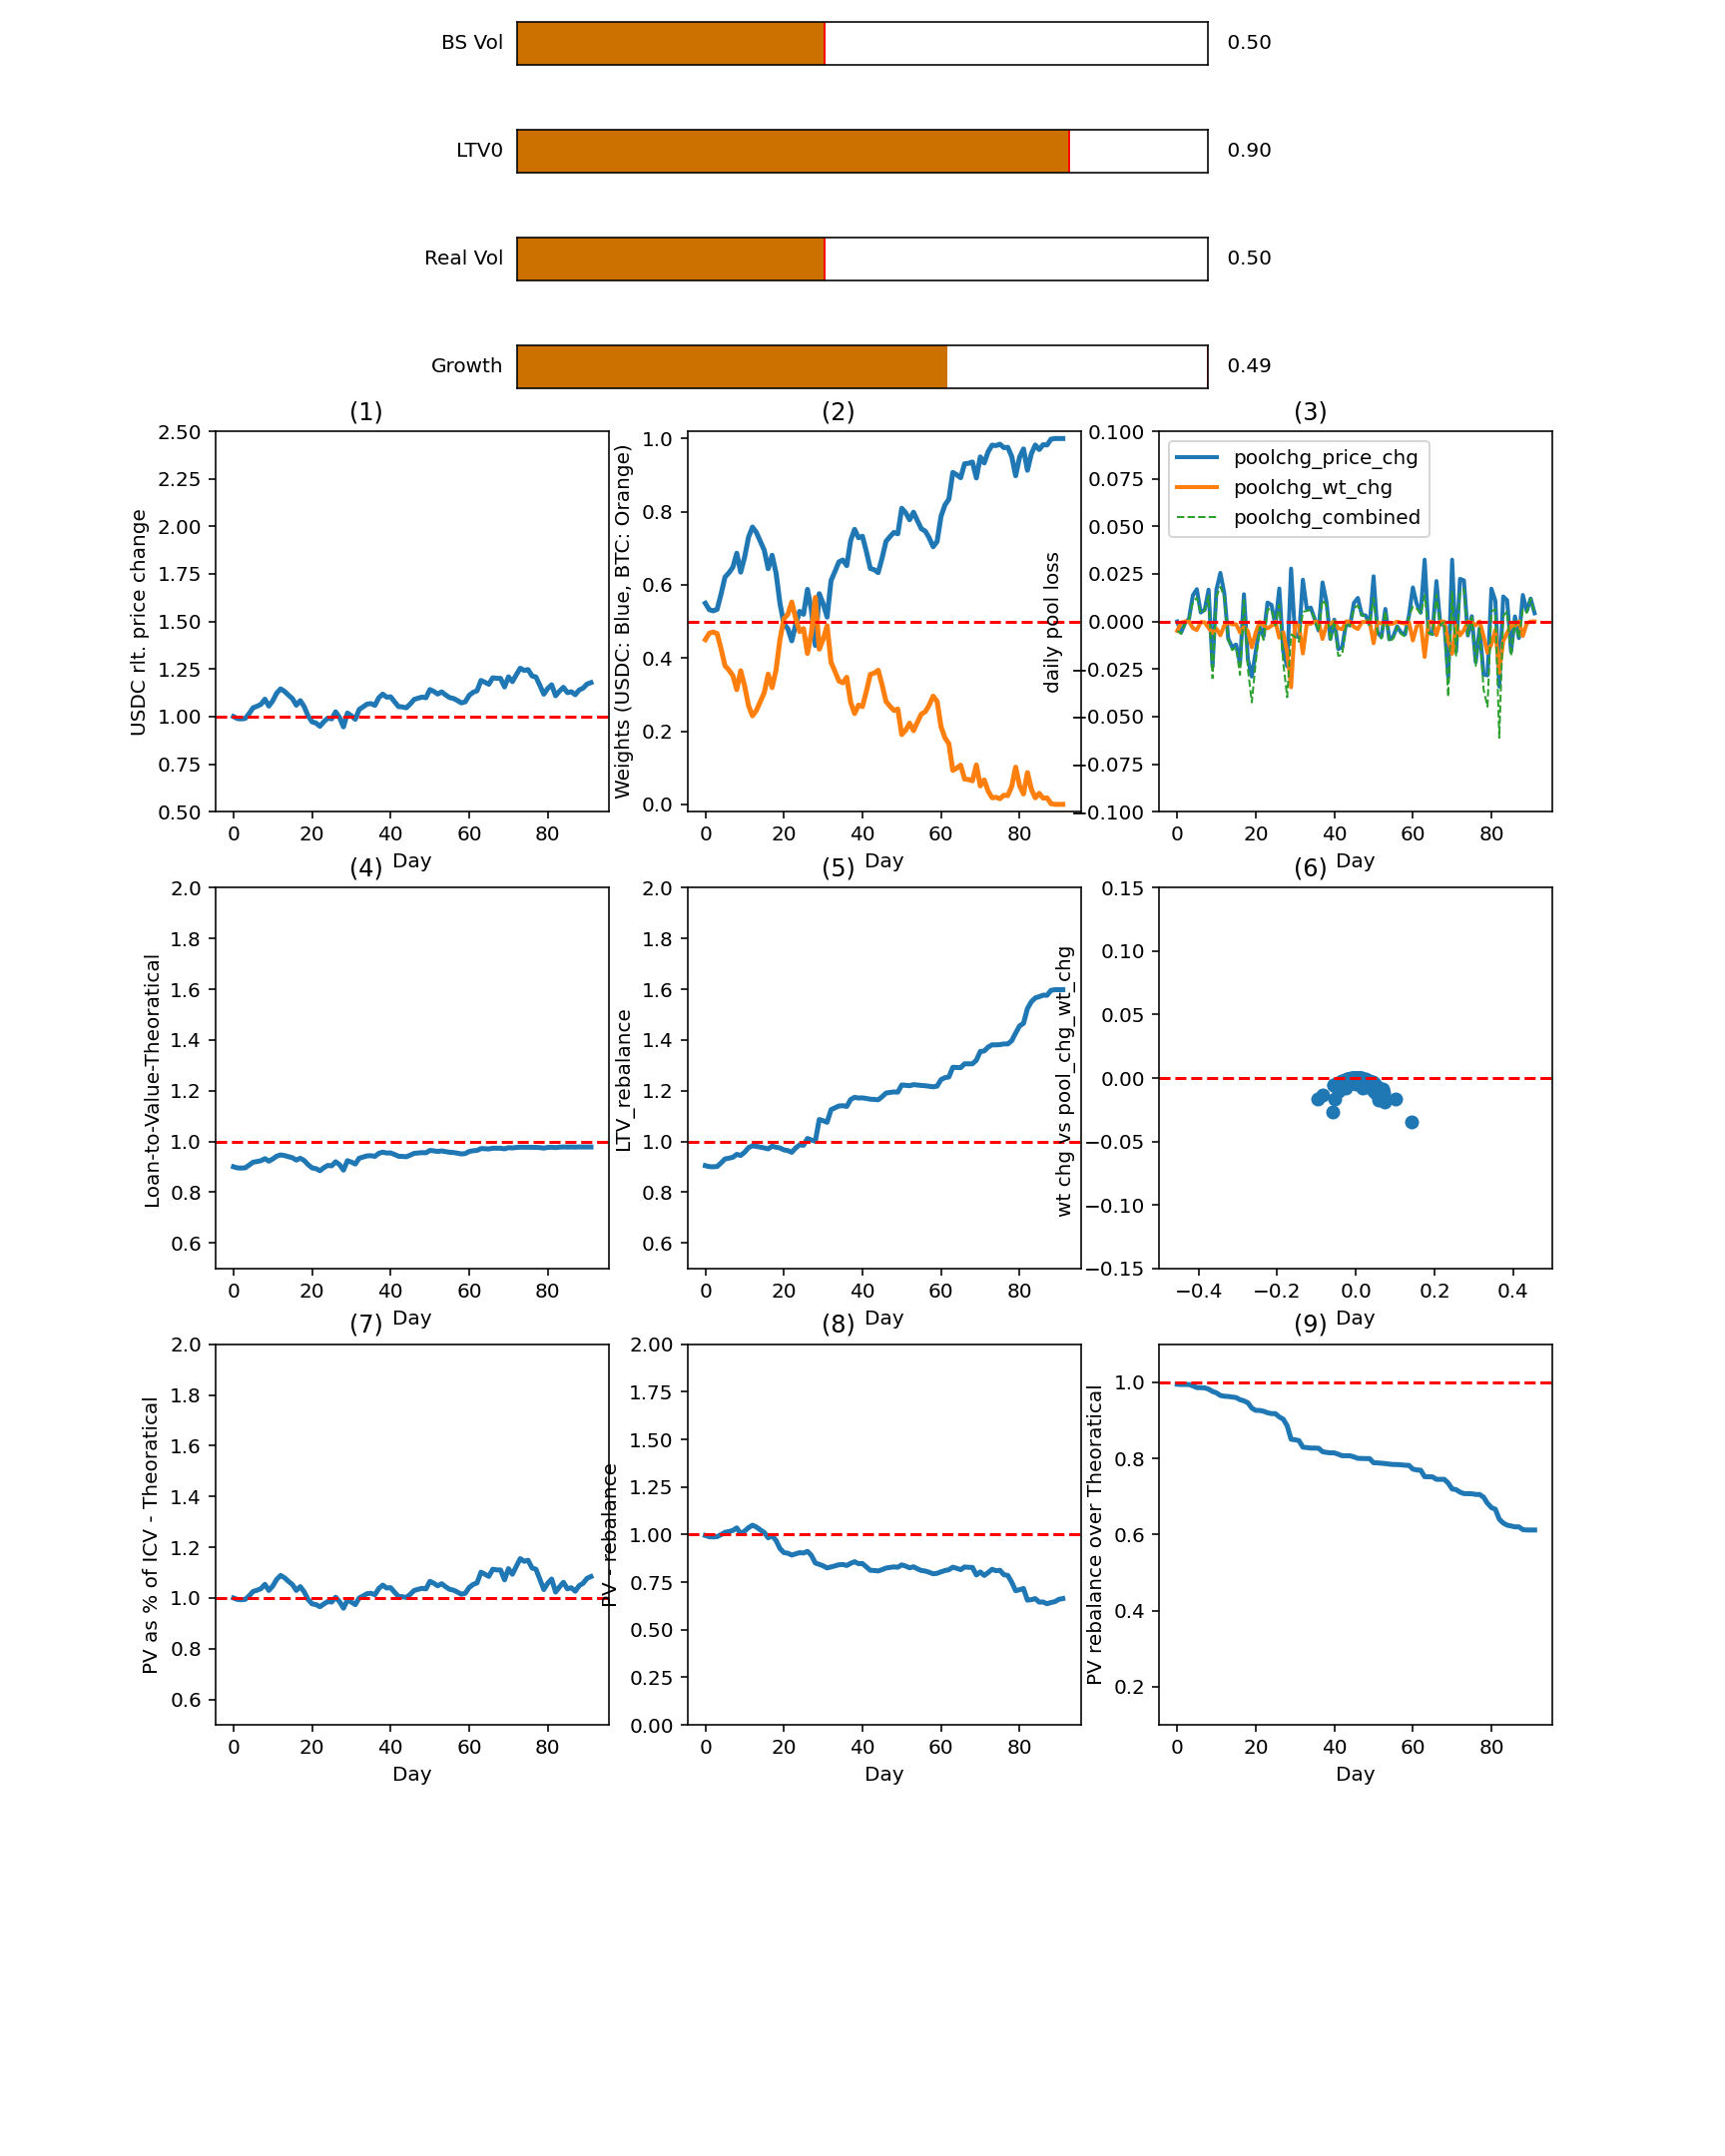

In [167]:
%matplotlib notebook
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(3,3,figsize=(12,15))
# Create main axis
fig.subplots_adjust(bottom=0.2, top=0.80)
# Create axes for sliders
ax_growth = fig.add_axes([0.3, 0.82, 0.4, 0.02])
ax_growth.spines['top'].set_visible(True)
ax_growth.spines['right'].set_visible(True)

ax_real_vol = fig.add_axes([0.3, 0.87, 0.4, 0.02])
ax_real_vol.spines['top'].set_visible(True)
ax_real_vol.spines['right'].set_visible(True)

ax_ltv = fig.add_axes([0.3, 0.92, 0.4, 0.02])
ax_ltv.spines['top'].set_visible(True)
ax_ltv.spines['right'].set_visible(True)

ax_bs_vol = fig.add_axes([0.3, 0.97, 0.4, 0.02])
ax_bs_vol.spines['top'].set_visible(True)
ax_bs_vol.spines['right'].set_visible(True)

# Create sliders
s_real_vol= Slider(ax=ax_real_vol, label='Real Vol', valmin=0.1, valmax=1.0, valinit=0.5, valfmt=' %1.2f ', facecolor='#cc7000')
s_growth = Slider(ax=ax_growth, label='Growth', valmin=-2, valmax=2, valinit=2, valfmt=' %1.2f', facecolor='#cc7000')
s_bs_vol= Slider(ax=ax_bs_vol, label='BS Vol', valmin=0.1, valmax=1.0, valinit=0.5, valfmt=' %1.2f ', facecolor='#cc7000')
s_ltv = Slider(ax=ax_ltv, label='LTV0', valmin=0.7, valmax=0.95, valinit=0.9, valfmt=' %1.2f', facecolor='#cc7000')

# Plot default data
t =  np.linspace(91,0,92)/365
real_vol_0 = 0.5
growth_0 = 2
ltv0 = 0.9
bs_vol0 = 0.5
y_price = 1/35000
Collateral = 200
pool_init_x = 100 
pool_init_y = 3500000
pool_init_wx = 0.5
_data = get_episode_full(t,y_price, Collateral, LTV0, bs_vol, Growth_rate, Real_vol, pool_init_x, pool_init_y, pool_init_wx)

x = _data.index.values
y1 = _data['y_price']/y_price
y2a = _data['w_ytoken']
y2b = 1-_data['w_ytoken']    
y3 = _data['ltv']
y4 = _data['ltv_rebalance']
y5 = _data['pvcr']
y6 = _data['pvcr_rebalance']
y7a = _data['pool_chg_price_chg']
y7b = _data['pool_chg_wt_chg']
y8 = _data['wt_chg']
y9 = _data['pvcr_rebal_theory']

f_d1, = axs[0,0].plot(x, y1, linewidth=2.5)
f_d2a, = axs[0,1].plot(x, y2a, linewidth=2.5)
f_d2b, = axs[0,1].plot(x, y2b, linewidth=2.5)
f_d3, = axs[1,0].plot(x, y3, linewidth=2.5)
f_d4, = axs[1,1].plot(x, y4, linewidth=2.5)
f_d5, = axs[2,0].plot(x, y5, linewidth=2.5)
f_d6, = axs[2,1].plot(x, y6, linewidth=2.5)
f_d7a, = axs[0,2].plot(x, y7a, linewidth =2, label= 'poolchg_price_chg')
f_d7b, = axs[0,2].plot(x, y7b, linewidth =2, label= 'poolchg_wt_chg')
f_d7c, = axs[0,2].plot(x, y7a+y7b, linewidth =1, label= 'poolchg_combined', linestyle='--')
f_d8, = axs[1,2].plot(y8, y7b, marker= 'o', linestyle = 'None')
f_d9, = axs[2,2].plot(x, y9, linewidth =2.5)

axs[0,0].set_ylim(0.5,2.5)
axs[0,0].axhline(y = 1, color = 'r', linestyle = '--')
axs[0,1].set_ylim(-0.02,1.02)
axs[0,1].axhline(y = 0.5, color = 'r', linestyle = '--')
axs[1,0].set_ylim(0.5,2)
axs[1,0].axhline(y = 1, color = 'r', linestyle = '--')
axs[1,1].set_ylim(0.5,2)
axs[1,1].axhline(y = 1, color = 'r', linestyle = '--')
axs[2,0].set_ylim(0.5,2)
axs[2,0].axhline(y = 1, color = 'r', linestyle = '--')
axs[2,1].set_ylim(0,2)
axs[2,1].axhline(y = 1, color = 'r', linestyle = '--')
axs[0,2].set_ylim(-0.1,0.1)
axs[0,2].axhline(y = 0, color = 'r', linestyle = '--')
axs[1,2].set_ylim(-0.15,0.15)
axs[1,2].set_xlim(-0.5,0.5)

axs[1,2].axhline(y = 0, color = 'r', linestyle = '--')
axs[2,2].set_ylim(0.1,1.1)
axs[2,2].axhline(y = 1, color = 'r', linestyle = '--')


axs[0,0].set_ylabel('USDC rlt. price change')
axs[0,1].set_ylabel('Weights (USDC: Blue, BTC: Orange)')
axs[1,0].set_ylabel('Loan-to-Value-Theoratical')
axs[1,1].set_ylabel('LTV_rebalance') 
axs[2,0].set_ylabel('PV as % of ICV - Theoratical')
axs[2,1].set_ylabel('PV - rebalance')
axs[0,2].set_ylabel('daily pool loss')
axs[1,2].set_ylabel('wt chg vs pool_chg_wt_chg ')
axs[2,2].set_ylabel('PV rebalance over Theoratical')
for i in range(3):
    for j in range(3):
        axs[i,j].set_xlabel('Day')
        axs[i,j].set_title('({})            '.format(3*i+j+1))

axs[0,2].legend(loc="upper left")

# Update values
def update(val):
    _real_vol = s_real_vol.val
    _growth = s_growth.val
    _bs_vol = s_bs_vol.val
    _ltv = s_ltv.val
    
    #_data = gen_data_vec(t, BTC, Collateral, _ltv, _bs_vol, _growth, _real_vol)
    _data = get_episode_full(t,y_price, Collateral, _ltv, _bs_vol, _growth, _real_vol, pool_init_x, pool_init_y, pool_init_wx)

    x = _data.index.values
    _y1 = _data['y_price']/y_price
    _y2a = _data['w_ytoken']
    _y2b = 1-_data['w_ytoken']    
    _y3 = _data['ltv']
    _y4 = _data['ltv_rebalance']
    _y5 = _data['pvcr']
    _y6 = _data['pvcr_rebalance']
    _y7a = _data['pool_chg_price_chg']
    _y7b = _data['pool_chg_wt_chg']
    _y8 = _data['wt_chg']
    _y9 = _data['pvcr_rebal_theory']

    
    f_d1.set_data(x,_y1)
    f_d2a.set_data(x,_y2a)
    f_d2b.set_data(x,_y2b)
    f_d3.set_data(x,_y3)
    f_d4.set_data(x,_y4)
    f_d5.set_data(x,_y5)
    f_d6.set_data(x,_y6)
    f_d7a.set_data(x,_y7a)
    f_d7b.set_data(x,_y7b)
    f_d7c.set_data(x,_y7a+_y7b)
    f_d8.set_data(_y8,_y7b)
    f_d9.set_data(x,_y9)
    fig.canvas.draw_idle()

s_real_vol.on_changed(update)
s_growth.on_changed(update)
s_ltv.on_changed(update)
s_bs_vol.on_changed(update)

plt.show()



<IPython.core.display.Javascript object>


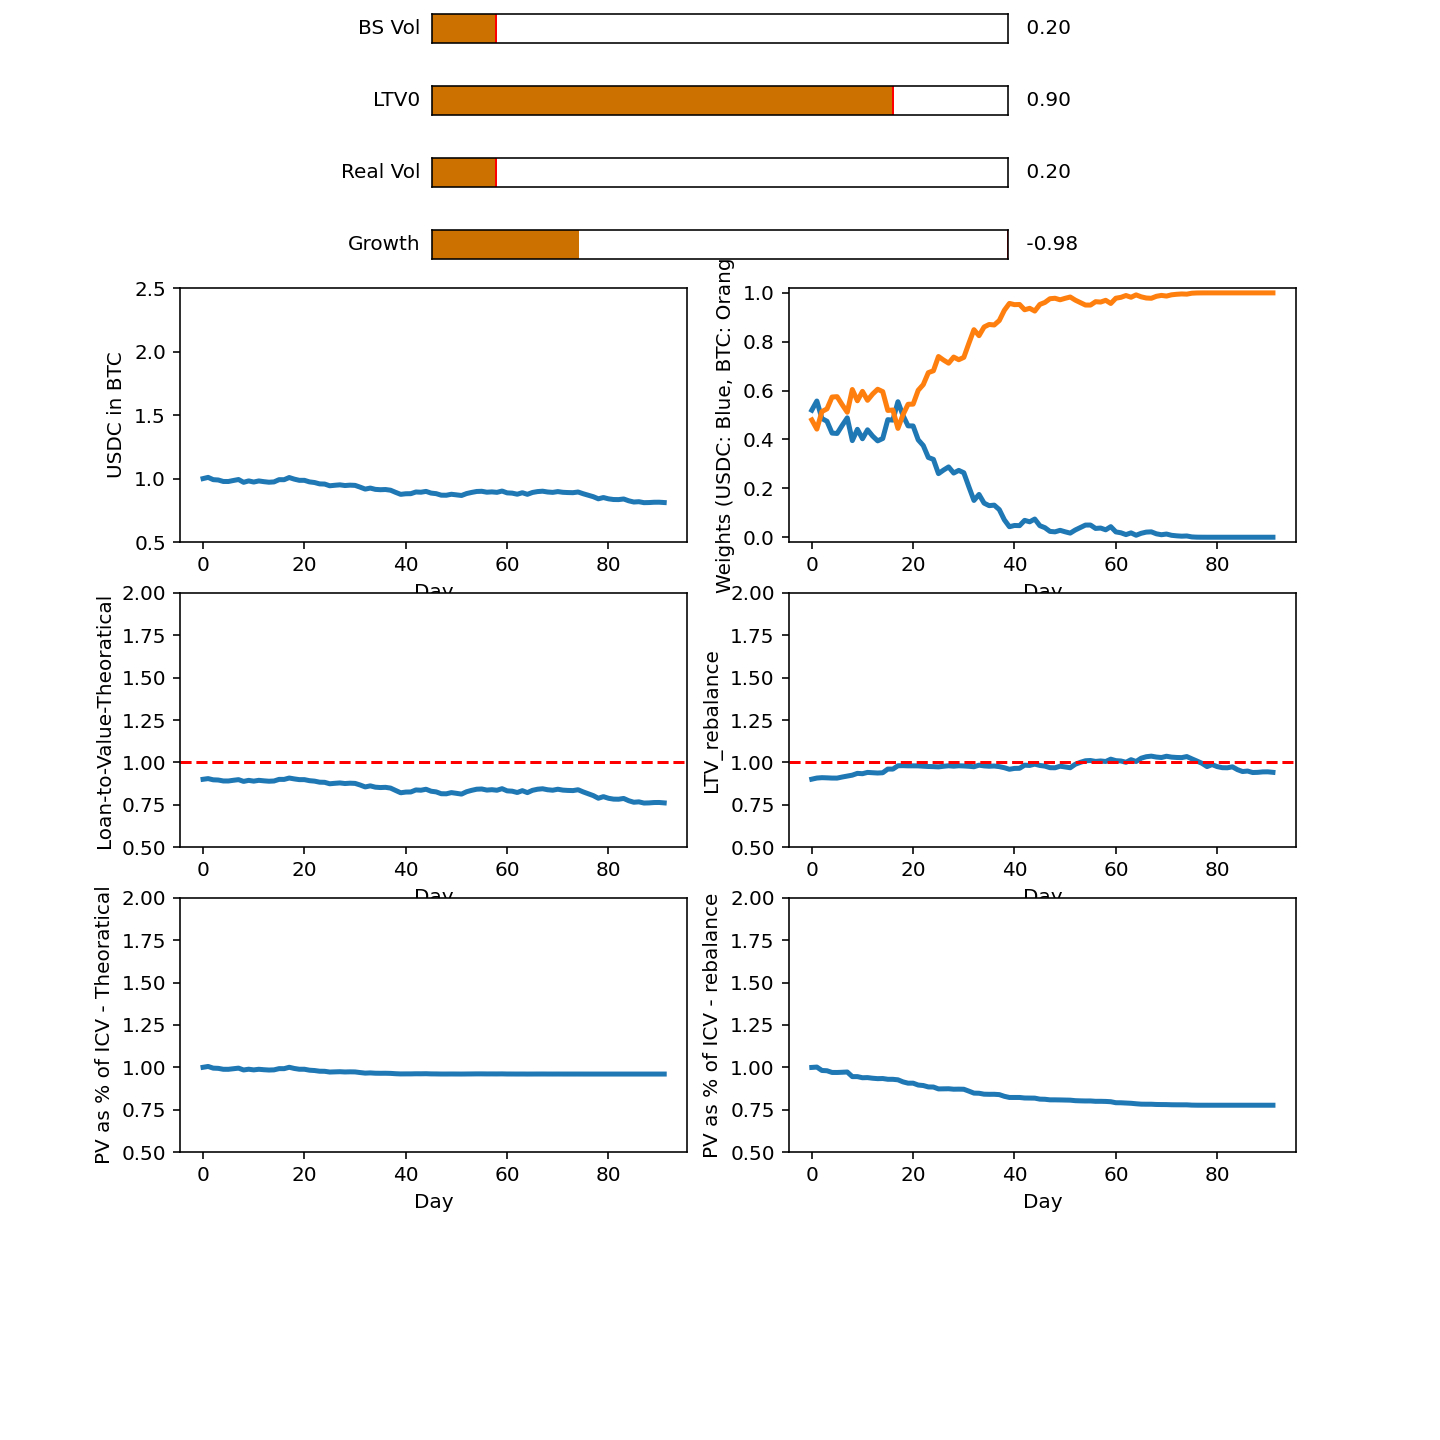

In [74]:
%matplotlib notebook
%matplotlib notebook

import matplotlib.pyplot as plt 
fig, axs = plt.subplots(3,2,figsize=(10,10))
# Create main axis
fig.subplots_adjust(bottom=0.2, top=0.80)
# Create axes for sliders
ax_growth = fig.add_axes([0.3, 0.82, 0.4, 0.02])
ax_growth.spines['top'].set_visible(True)
ax_growth.spines['right'].set_visible(True)

ax_real_vol = fig.add_axes([0.3, 0.87, 0.4, 0.02])
ax_real_vol.spines['top'].set_visible(True)
ax_real_vol.spines['right'].set_visible(True)

ax_ltv = fig.add_axes([0.3, 0.92, 0.4, 0.02])
ax_ltv.spines['top'].set_visible(True)
ax_ltv.spines['right'].set_visible(True)

ax_bs_vol = fig.add_axes([0.3, 0.97, 0.4, 0.02])
ax_bs_vol.spines['top'].set_visible(True)
ax_bs_vol.spines['right'].set_visible(True)

# Create sliders
s_real_vol= Slider(ax=ax_real_vol, label='Real Vol', valmin=0.1, valmax=1.0, valinit=0.2, valfmt=' %1.2f ', facecolor='#cc7000')
s_growth = Slider(ax=ax_growth, label='Growth', valmin=-2, valmax=2, valinit=2, valfmt=' %1.2f', facecolor='#cc7000')
s_bs_vol= Slider(ax=ax_bs_vol, label='BS Vol', valmin=0.1, valmax=1.0, valinit=0.2, valfmt=' %1.2f ', facecolor='#cc7000')
s_ltv = Slider(ax=ax_ltv, label='LTV0', valmin=0.7, valmax=0.95, valinit=0.9, valfmt=' %1.2f', facecolor='#cc7000')

# Plot default data
t =  np.linspace(91,0,92)/365
real_vol_0 = 0.2
growth_0 = 2
ltv0 = 0.9
bs_vol0 = 0.2
y_price = 1/35000
Collateral = 200
pool_init_x = 100 
pool_init_y = 3500000
pool_init_wx = 0.5
_data = get_episode_full(t,y_price, Collateral, LTV0, bs_vol, Growth_rate, Real_vol, pool_init_x, pool_init_y, pool_init_wx)

x = _data.index.values
y1 = _data['y_price']/y_price
y2a = _data['w_ytoken']
y2b = 1-_data['w_ytoken']    
y3 = _data['ltv']
y4 = _data['ltv_rebalance']
y5 = _data['pvcr']
y6 = _data['pvcr_rebalance']

f_d1, = axs[0,0].plot(x, y1, linewidth=2.5)
f_d2a, = axs[0,1].plot(x, y2a, linewidth=2.5)
f_d2b, = axs[0,1].plot(x, y2b, linewidth=2.5)
f_d3, = axs[1,0].plot(x, y3, linewidth=2.5)
f_d4, = axs[1,1].plot(x, y4, linewidth=2.5)
f_d5, = axs[2,0].plot(x, y5, linewidth=2.5)
f_d6, = axs[2,1].plot(x, y6, linewidth=2.5)
axs[0,0].set_ylim(0.5,2.5)
axs[0,1].set_ylim(-0.02,1.02)
axs[1,0].set_ylim(0.5,2)
axs[1,0].axhline(y = 1, color = 'r', linestyle = '--')
axs[1,1].set_ylim(0.5,2)
axs[1,1].axhline(y = 1, color = 'r', linestyle = '--')
axs[2,0].set_ylim(0.5,2)
axs[2,1].set_ylim(0.5,2)

axs[0,0].set_ylabel('USDC in BTC')
axs[0,1].set_ylabel('Weights (USDC: Blue, BTC: Orange)')
axs[1,0].set_ylabel('Loan-to-Value-Theoratical')
axs[1,1].set_ylabel('LTV_rebalance') 
axs[2,0].set_ylabel('PV as % of ICV - Theoratical')
axs[2,1].set_ylabel('PV as % of ICV - rebalance')

for i in range(3):
    for j in range(2):
        axs[i,j].set_xlabel('Day')


# Update values
def update(val):
    _real_vol = s_real_vol.val
    _growth = s_growth.val
    _bs_vol = s_bs_vol.val
    _ltv = s_ltv.val
    
    #_data = gen_data_vec(t, BTC, Collateral, _ltv, _bs_vol, _growth, _real_vol)
    _data = get_episode_full(t,y_price, Collateral, _ltv, _bs_vol, _growth, _real_vol, pool_init_x, pool_init_y, pool_init_wx)

    x = _data.index.values
    _y1 = _data['y_price']/y_price
    _y2a = _data['w_ytoken']
    _y2b = 1-_data['w_ytoken']    
    _y3 = _data['ltv']
    _y4 = _data['ltv_rebalance']
    _y5 = _data['pvcr']
    _y6 = _data['pvcr_rebalance']
    
    f_d1.set_data(x,_y1)
    f_d2a.set_data(x,_y2a)
    f_d2b.set_data(x,_y2b)
    f_d3.set_data(x,_y3)
    f_d4.set_data(x,_y4)
    f_d5.set_data(x,_y5)
    f_d6.set_data(x,_y6)

    fig.canvas.draw_idle()

s_real_vol.on_changed(update)
s_growth.on_changed(update)
s_ltv.on_changed(update)
s_bs_vol.on_changed(update)

plt.show()


### Simulation results:
For each selected combination (1) to (4), run the process 100 times and count the number of events that LVT(t) > 1 at any time point.  Report the frequency by LTV0 and growth rate for a given volatility setup.     
    
For example this is the simulation results when growth rate volatility is high, and black sholes volatility is under-estimated. 
The size of button indicate the chance of default when LVT is hight, even the growth rate is low.    


In [5]:
# simulation 2 
def ltv_simulation(s, LTV0, bs_vol, Growth_rate, Real_vol):
    freq = 0 
    for k in range(0,s):
        _out = gen_data_vec_btc(t, y_price, Collateral, LTV0, bs_vol, Growth_rate, Real_vol)
        freq+= (max(_out['ltv'])>=1)
    return np.array([freq/s, _out.pvcr.mean(), _out.pvcr.std()])

In [16]:

# Generate whole simulation output table for different combinations of parameters  

xyz = []
i =0 
t = np.linspace(91,0,92)/365
np.random.seed(0)
y_price= 1/35000
Collateral = 200
for real_vol in np.linspace(0.1, 1.0, 10):
    for growth in np.linspace(0.3, 3, 10):
        for ltv in np.linspace(0.7, 0.95, 11):
            for bs_vol in np.linspace(0.1, 1.0, 10):
                if i%1000 == 0: 
                    print(i)
                z = ltv_simulation(100, ltv, bs_vol, growth, real_vol)
                param = np.array([real_vol, growth, ltv, bs_vol])
                xyz.append(np.concatenate((param, z), axis = None))
                i+=1
_data = pd.DataFrame(np.array(xyz))
_data.columns = ['real_vol', 'growth', 'ltv', 'bs_vol', 'default_risk', 'pvcr_mean', 'pvcr_std']
# #_data.to_csv('./ALEX/simulation2_out.csv')


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [18]:
# df_plot = pd.read_csv('./simulation2_out.csv')
# df_plot.drop('Unnamed: 0', 1, inplace=True)
# df_plot.describe()
df_plot = _data

In [20]:
%matplotlib inline 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random

def series(real_vol, bs_vol, target_var):
    _x, _y = 'growth', 'ltv'
    _df = df_plot[(df_plot.real_vol <real_vol+1e-4) &(df_plot.real_vol >real_vol-1e-4) \
                  & (df_plot.bs_vol< bs_vol+1e-4) & (df_plot.bs_vol>bs_vol-1e-4)]
    x, y, z = _df[_x], _df[_y], _df[target_var]*100    
    sc = plt.scatter(x,y, s=z)
    plt.legend(*sc.legend_elements("sizes", num = 10))
    plt.xlabel('growth (of borrowed token price)')
    plt.ylabel('ltv')
    plt.xlim(0,4)
    plt.title(target_var)
    return()
plt.rcParams['figure.figsize'] = (10,6)
fig2 = interact(series, real_vol=(0.1, 1, 0.1), bs_vol = (0.1, 1, 0.1), target_var= ['default_risk'])

interactive(children=(FloatSlider(value=0.5, description='real_vol', max=1.0, min=0.1), FloatSlider(value=0.5,…

In [ ]:

# import matplotlib.pyplot as plt
# from matplotlib import cm
# import numpy as np
# from celluloid import Camera
# import matplotlib.animation

# camera = Camera(plt.figure())
# _x, _y = 'growth', 'ltv'
# i,j = 0,0
# for real_vol in np.linspace(0.1, 0.5, 11):
#     i += 1
#     for bs_vol in np.linspace(0.1, 0.5, 11):
#         j += 1    
#         _df = df_plot[(df_plot.real_vol <real_vol+1e-4) &(df_plot.real_vol >real_vol-1e-4) \
#                       & (df_plot.bs_vol< bs_vol+1e-4) & (df_plot.bs_vol>bs_vol-1e-4)]
#         x, y, z = _df[_x], _df[_y], _df['default_risk']*100       
#         sc = plt.scatter(x,y, s=z)
#         plt.legend(*sc.legend_elements("sizes", num = 10))
#         plt.xlabel('growth (of borrowed token price)')
#         plt.ylabel('ltv')
#         plt.title('Observed freq. of default (LTV>=1)')
#         plt.xlim(0,4)
#         plt.text(0.5, 0.8, "real_vol={:.2%}, bs_vol= {:.2%}".format(real_vol, bs_vol))
#         if i%3 ==0 & j%3 ==0:
#             camera.snap()
# camera.snap()         
# anim = camera.animate()
# writergif = matplotlib.animation.PillowWriter(fps=3)
# anim.save('default_simulation.gif', writer=writergif)
# # numpoints = 10
# # points = np.random.random((2, numpoints))
# # colors = cm.rainbow(np.linspace(0, 1, numpoints))
# # camera = Camera(plt.figure())
# # for _ in range(100):
# #     points += 0.1 * (np.random.random((2, numpoints)) - .5)
# #     plt.scatter(*points, c=colors, s=100)
# #     camera.snap()
